# Data Visualisation using Big Data
## Created by Zac Hatfield-Dodds

In this exercise we'll be visualising historical weather data using Big Data sets from the NCI.

Possible Scenario: A regional farm cooperative trying to decide what seed crops they should grow for coming years

This data has been produced by the Terrestrial Ecosystem Research Network's (TERN) Ecosystem Modelling and Scaling Infrastructure (eMAST) project, using physics-based simulations to fill in the gaps in observations going back to 1970. Using "reanalysis" techniques like this, we can turn point observations into gridded data!

It's hosted by the National Computational Infrastructure (NCI) on ANU campus, so access should be fast! You can read about the dataset here, and access it here (click the variable, dataset, then "1. OPeNDAP" and use the "data URL"). This is quite a process, but worth it to access to world-leading research datasets.
Loading the data

We'll start with some scaffolding code to demonstrate loading the data, then it's over to you to load any other variables that you might be interested in.


In [0]:
# As usual, we start with our standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# And for remote sensing, we add Xarray - it's inspired by Pandas, and designed
# to handle groups of multi-dimensional arrays.  See http://xarray.pydata.org/
import xarray as xr

# Finally, we'll use a "magic" - that's the official name - to show plots inline.
%matplotlib inline
# (starting with `%` is invalid syntax in Python, so IPython and Jupyter use
#  it to denote special commands that change e.g. how they render plots for us)

In [0]:
!pip install netCDF4

     |████████████████████████████████| 4.1MB 4.7MB/s 
     |████████████████████████████████| 317kB 48.5MB/s 


In [0]:
# Open the annual mean air temperature dataset, over the internet.
# Rainfall data url:    http://dapds00.nci.org.au/thredds/dodsC/rr9/eMAST_data/eMAST-R-Package/eMAST-R-Package_v1-1_rainfall_yearly_0-01deg_1970-2012
# Temperature data url: http://dapds00.nci.org.au/thredds/dodsC/rr9/eMAST_data/eMAST-R-Package/eMAST-R-Package_v1-1_temperature-mean_yearly_0-01deg_1970-2012
ds = xr.open_dataset(
    "http://dapds00.nci.org.au/thredds/dodsC/rr9/eMAST_data/eMAST-R-Package/eMAST-R-Package_v1-1_moisture-index_monthly_0-01deg_1970-2012",
)
print(f"This is {ds.nbytes/1e9:.2f} gigabytes of data!")
ds

This is 29.47 gigabytes of data!


<xarray.Dataset>
Dimensions:         (lat: 3474, lon: 4110, time: 516)
Coordinates:
  * lat             (lat) float32 -9.005 -9.015 -9.025 ... -43.725 -43.735
  * lon             (lon) float32 112.905 112.915 112.925 ... 153.985 153.995
  * time            (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2012-12-01
Data variables:
    crs             int8 ...
    moisture_index  (time, lat, lon) float32 ...
Attributes:
    Conventions:                CF-1.6
    title:                      Moisture index: eMAST-R-Package 2.0, 0.01 deg...
    institution:                Macquarie University, Sydney, Australia
    history:                    Produced using eMAST-R-Package 2.0
    source:                     eMAST-R-Package 2.0
    references:                 Rhys Whitley, Bradley Evans, Julie Pauwels, M...
    calendar:                   gregorian
    _FillValue:                 b'-9999'
    valid_min:                  1970-01-01T00:00:01Z
    valid_max:                  2012-12-31T23:59:5

So this is a fairly large dataset - 29.5GB of data, a substantial time dimension, and _lots_ of metadata describing the data and its provenance.  So far, so good.

In [0]:
# There are special rules for time-based selection in Pandas and Xarray.
#     (You can use any prefix of the YYYY-MM-DDThh:mm:ss datetime syntax
#      specified in ISO8601 to select all time-steps starting with that prefix)
# or, "just use strings instead of integers to select years"
moisture201201 = ds.moisture_index.sel(time="2012-01").squeeze()
moisture201201

<xarray.DataArray 'moisture_index' (lat: 3474, lon: 4110)>
[14278140 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -9.005 -9.015 -9.025 ... -43.715 -43.725 -43.735
  * lon      (lon) float32 112.905 112.915 112.925 ... 153.975 153.985 153.995
    time     datetime64[ns] 2012-01-01
Attributes:
    grid_mapping:   crs
    long_name:      Moisture index
    cell_methods:   nan
    standard_name:  moisture_index
    units:          no�units

The OPeNDAP protocol we're using to load the data even allows us to select parts of an array without downloading the whole thing!  This is going to be important for this lab, because if you load the whole thing at once it won't take much to run out of memory.  Let's load this slice to take a closer look.

*(sanity check: ~2.5GB / ~50 time steps is ~50MB; and that's trivial to work with)*

In [0]:
moisture201201.load()

<xarray.DataArray 'moisture_index' (lat: 3474, lon: 4110)>
array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -9.005 -9.015 -9.025 ... -43.715 -43.725 -43.735
  * lon      (lon) float32 112.905 112.915 112.925 ... 153.975 153.985 153.995
    time     datetime64[ns] 2012-01-01
Attributes:
    grid_mapping:   crs
    long_name:      Moisture index
    cell_methods:   nan
    standard_name:  moisture_index
    units:          no�units

Uh-oh, that looks like a missing data value to me!  `-9999` is *physically impossible* as a measurement of temperature in degrees Celsius (or Farenheight or Kelvin), and just as impossible for rainfall data.  What's going with that?  And why is the standard_name attribute `air_temperature`???

The first answer involves Xarray's `decode_cf` functionality and the [CF Conventions](http://cfconventions.org/) `_FillValue` attribute, but that's plenty of hints.  The CF conventions also define the meaning of all the other attributes, if you're interested in reading up on data, metadata, and interoperability.

Note the change of colormap.

Which colormap might work best? https://matplotlib.org/users/colormaps.html

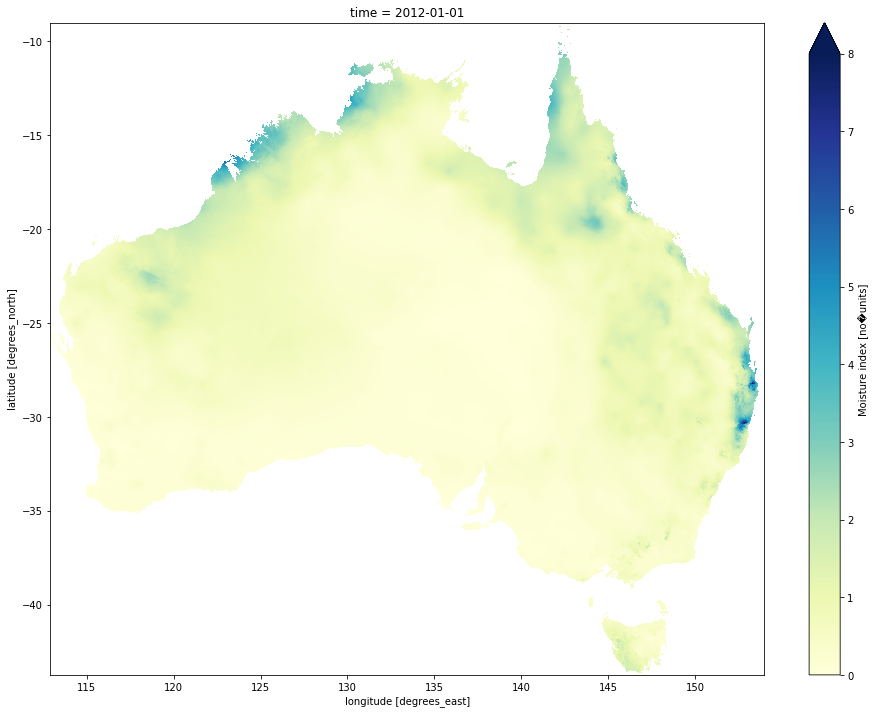

In [0]:
#fig = plt.gcf()
#@savefig
moisture201201.where(moisture201201 != -9999).plot.imshow(vmin=0, vmax=8, figsize=(16,12), cmap='YlGnBu')
# plt.savefig("2012-01-01-moisture.png")  # savefig will save your last plot(s) to a file

Let's plot one year of data by month and see if we can see some patterns

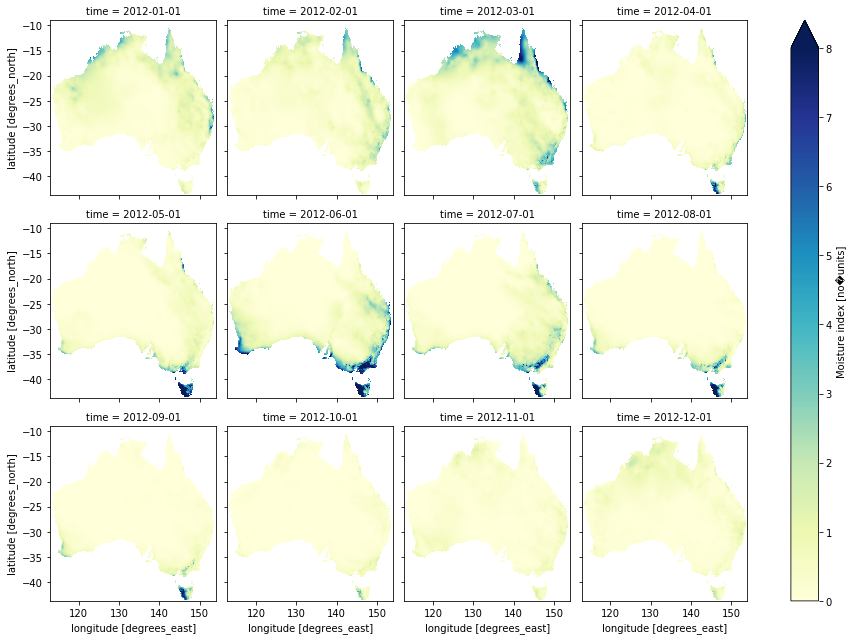

In [0]:
month_strings = ["01","02","03","04","05","06","07","08","09","10","11","12"]
month_moistures = []
for m in month_strings:
    mm = ds.moisture_index.sel(time="2012-"+m).squeeze()
    mm = mm.where(mm!=-9999)
    month_moistures.append(mm)
moisture_xr = xr.concat(month_moistures, dim="time")
moisture_xr.plot.imshow(col='time',col_wrap=4,vmin=0, vmax=8,cmap='YlGnBu')

Now lets look at one month (June in this case) across the years 1998 to 2013.  
What is different?  What stories can you tell? What is missing?

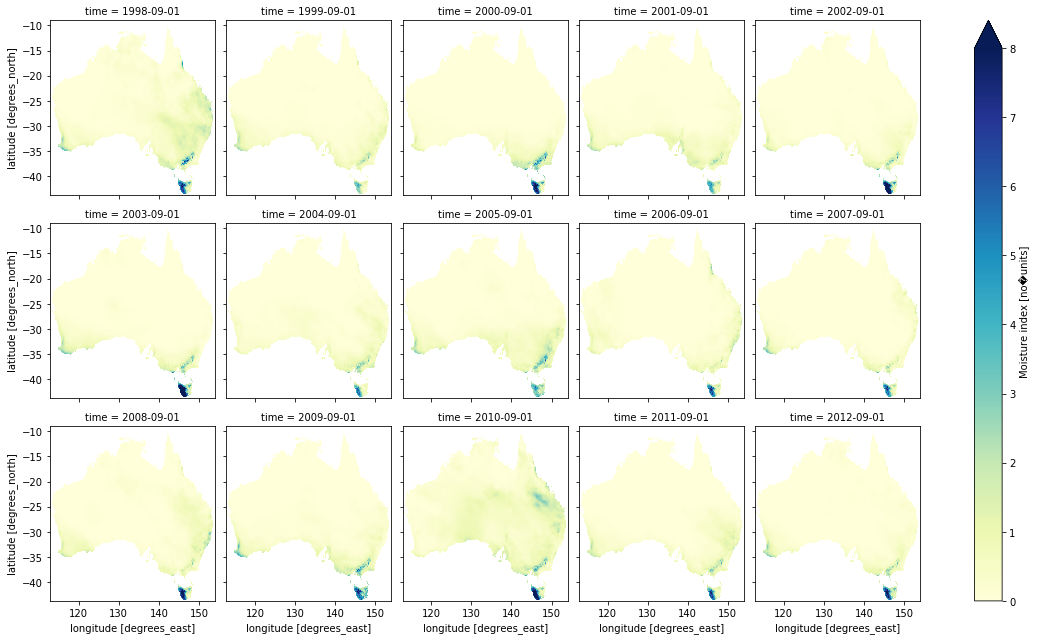

In [0]:
ann06_moistures = []
for y in range(1998,2013):
    am = ds.moisture_index.sel(time=str(y)+"-09").squeeze()
    am = am.where(am!=-9999)
    ann06_moistures.append(am)
ann06_xr = xr.concat(ann06_moistures, dim="time")
ann06_xr.plot.imshow(col='time',col_wrap=5,vmin=0,vmax=8,cmap='YlGnBu')

Feel free to explore